In [1]:
# Импорт библиотек
import geopandas as gpd
import shapely.geometry
import shapely.ops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import numpy as np
from pyproj import CRS, Transformer

# --- Загрузка данных ---

# Путь к файлу с входными данными
input_file = "./data/input.geojson"

# Чтение файла GeoJSON
try:
    data = gpd.read_file(input_file)
except FileNotFoundError:
    print(f"Ошибка: Файл {input_file} не найден.")
    exit()



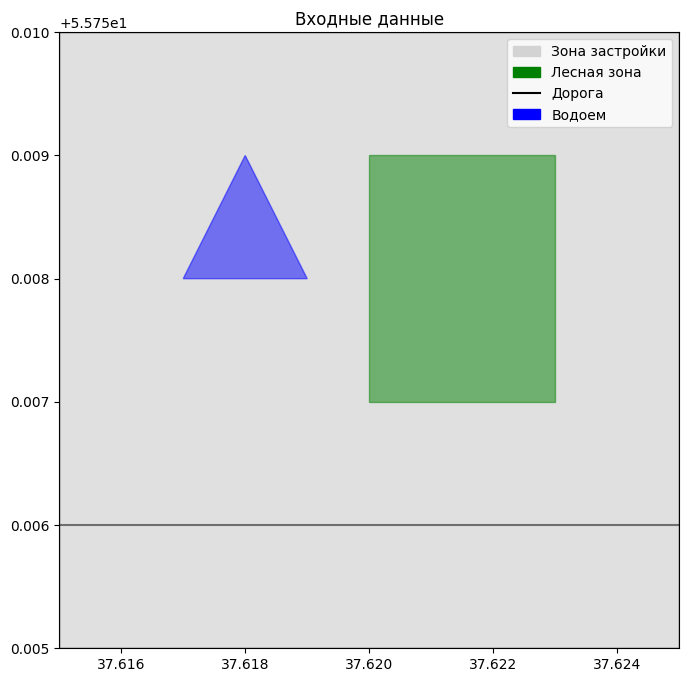

In [2]:
# --- Визуализация входных данных ---

fig, ax = plt.subplots(figsize=(8, 8))

# Отрисовка зоны застройки
buildable_area_series = data[data['id'] == 'buildable_area']
for geom in buildable_area_series.geometry:
    if isinstance(geom, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(geom.exterior.coords), facecolor='lightgray', edgecolor='black', alpha=0.7)
        ax.add_patch(polygon)

# Добавляем label вручную
buildable_area_patch = mpatches.Patch(color='lightgray', label='Зона застройки')


# Отрисовка зон с ограничениями
restricted_areas_series = data[data['restriction'] == 'no_build']
legend_handles = [buildable_area_patch] # список для ручного добавления в легенду

for index, row in restricted_areas_series.iterrows():
    #  Выбираем цвет в зависимости от типа зоны
    if row['id'] == 'forest':
        color = 'green'
    elif row['id'] == 'road':
        color = 'black'
    elif row['id'] == 'water':
        color = 'blue'
    else:
        color = 'red' # Если вдруг неизвестный тип

    geom = row['geometry']
    if isinstance(geom, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(geom.exterior.coords), color=color, alpha=0.5)
        ax.add_patch(polygon)
        legend_handles.append(mpatches.Patch(color=color, label=row['name']))
    elif isinstance(geom, shapely.geometry.LineString):
        line = mlines.Line2D(*zip(*geom.coords), color=color, alpha=0.5)
        ax.add_line(line)
        legend_handles.append(mlines.Line2D([0], [0], color=color, label=row['name']))


# Добавление легенды
plt.legend(handles=legend_handles)  # Передаем список handles

plt.title("Входные данные")

# Установка пределов осей (важно для корректного отображения)
minx, miny, maxx, maxy = data.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()



In [4]:
# --- Предобработка данных ---

# Проверка геометрий на корректность
for index, row in data.iterrows():
    if not row['geometry'].is_valid:
        print(f"Warning: Некорректная геометрия в строке {index}")
        # Исправление геометрии (если возможно)
        data.loc[index, 'geometry'] = row['geometry'].buffer(0)

# Получение зоны застройки
buildable_area = data[data['id'] == 'buildable_area']
if buildable_area.empty:
    print("Ошибка: Зона застройки не найдена.")
    exit()
buildable_area = buildable_area.geometry.union_all()
if not isinstance(buildable_area, shapely.geometry.Polygon):
    if isinstance(buildable_area, shapely.geometry.MultiPolygon):
        print("Warning: Зона застройки состоит из нескольких полигонов.")
        # Выбираем самый большой полигон, если их несколько
        buildable_area = max(buildable_area.geoms, key=lambda a: a.area)
    else:
        print("Ошибка: Зона застройки имеет некорректный тип")
        exit()



# Получение зон с ограничениями
restricted_areas = data[data['restriction'] == 'no_build']
restricted_areas = restricted_areas.geometry.union_all()

# --- Параметры застройки ---

# Задаем CRS (систему координат)
#  EPSG:4326 - WGS 84 (широта/долгота)
#  EPSG:32637 - UTM zone 37N (проекция, подходит для Москвы)
crs_wgs84 = CRS("EPSG:4326")
crs_utm = CRS("EPSG:32637")

# Создаем трансформер для перевода из WGS 84 в UTM и обратно
transformer_to_utm = Transformer.from_crs(crs_wgs84, crs_utm, always_xy=True)
transformer_from_utm = Transformer.from_crs(crs_utm, crs_wgs84, always_xy=True)


# Функция для перевода координат из WGS 84 в UTM
def to_utm(lon, lat):
    return transformer_to_utm.transform(lon, lat)

# Функция для перевода координат из UTM в WGS 84
def from_utm(x, y):
    return transformer_from_utm.transform(x, y)

# --- Параметры для разных типов объектов ---

#  Словарь с параметрами для разных типов
object_types = {
    "residential": {
        "density": 0.3,
        "min_distance": 10,  # в метрах
        "building_size": 5, # в метрах
        "color": "red" #Цвет для визуализации
    },
    "commercial": {
        "density": 0.1,
        "min_distance": 15,
        "building_size": 10,
        "color": "blue"
    },
     "park": {
        "density": 0.2,  # Плотность "зеленых насаждений"
        "min_distance": 5,  # Минимальное расстояние между деревьями
        "building_size": 3, # Размер "дерева"
        "color": "green"
    }
}

#  Переводим метры в градусы для КАЖДОГО типа, используя pyproj
for obj_type, params in object_types.items():
  #Берем среднюю точку участка для перевода
  center_lon, center_lat = buildable_area.centroid.x, buildable_area.centroid.y
  #Переводим в UTM
  center_x, center_y = to_utm(center_lon, center_lat)

  #Сдвигаемся на нужное расстояние в метрах
  x_dist = center_x + params["min_distance"]
  y_dist = center_y + params["building_size"]

  #Переводим обратно в WGS84
  lon_dist, lat_dist = from_utm(x_dist, y_dist)

  #Вычисляем разницу в градусах
  params["min_distance_deg"] =  max(abs(lon_dist - center_lon), abs(lat_dist - center_lat))
  params["building_size_deg"] = max(abs(lon_dist - center_lon), abs(lat_dist - center_lat))



In [5]:
# --- Создание сетки ---

# Границы зоны застройки
min_x, min_y, max_x, max_y = buildable_area.bounds

# Шаг сетки (Берем максимальный из всех минимальных)
grid_step = max([params["min_distance_deg"] for params in object_types.values()])

# Создание сетки точек
grid_points = []
x_coords = np.arange(min_x, max_x, grid_step)
y_coords = np.arange(min_y, max_y, grid_step)

for x in x_coords:
    for y in y_coords:
        point = shapely.geometry.Point(x, y)
        grid_points.append(point)

# Преобразование списка точек в GeoSeries
grid_points = gpd.GeoSeries(grid_points)

# --- Фильтрация сетки ---

#  Удаляем точки, если здание в этой точке выходит за границы или пересекается с запретными зонами
#  (с учетом building_size_deg - используем максимальный)
max_building_size_deg = max([params["building_size_deg"] for params in object_types.values()])

filtered_grid_points = []
for point in grid_points:
    building = shapely.geometry.box(point.x - max_building_size_deg / 2,
                                      point.y - max_building_size_deg / 2,
                                      point.x + max_building_size_deg / 2,
                                      point.y + max_building_size_deg / 2)
    if building.within(buildable_area) and (restricted_areas is None or not building.intersects(restricted_areas)):
        filtered_grid_points.append(point)


grid_points = gpd.GeoSeries(filtered_grid_points)
print(f"Количество точек после фильтрации: {len(grid_points)}")

# --- Размещение объектов (Жадный алгоритм) ---

placed_objects = []  #  Список для хранения ВСЕХ размещенных объектов
available_area_total = buildable_area.area #Общая доступная площадь

#  Перемешиваем точки для случайного размещения (один раз)
grid_points = grid_points.sample(frac=1).reset_index(drop=True)

#Размещаем разные типы
for obj_type, params in object_types.items():
    available_area = available_area_total * params["density"] #Вычисляем доступную площадь для данного типа
    print(f"Размещаем объекты типа {obj_type}. Доступная площадь: {available_area}")

    for point in grid_points:
        # Создание геометрии объекта
        building = shapely.geometry.box(point.x - params["building_size_deg"] / 2,
                                        point.y - params["building_size_deg"] / 2,
                                        point.x + params["building_size_deg"] / 2,
                                        point.y + params["building_size_deg"] / 2)

        # Проверка на пересечение с другими объектами
        intersects = False
        for other_obj in placed_objects: #Проверяем со всеми объектами
            if building.intersects(other_obj.buffer(params["min_distance_deg"])): #Используем min_dist для данного типа
                intersects = True
                break

        #Доп.проверка на вхождение в зону и отсутствие пересечения с ограничениями
        if not intersects and building.within(buildable_area) and (restricted_areas is None or not building.intersects(restricted_areas)):
            if building.area <= available_area:
                placed_objects.append(building) #Добавляем в общий список
                available_area -= building.area #Уменьшаем доступную площадь для данного типа
            else:
                print(f"Достигнут предел плотности застройки для типа {obj_type}.")
                break

print(f"Всего размещено объектов: {len(placed_objects)}")



Количество точек после фильтрации: 609
Размещаем объекты типа residential. Доступная площадь: 1.4999999999983373e-05
Размещаем объекты типа commercial. Доступная площадь: 4.999999999994458e-06
Размещаем объекты типа park. Доступная площадь: 9.999999999988917e-06
Всего размещено объектов: 609


In [6]:
# --- Генерация GeoJSON ---

# Создание списка Feature для ВСЕХ объектов
all_features = []
obj_counter = 0 #Счетчик для id
for obj, obj_type in zip(placed_objects, [list(object_types.keys())[i%len(object_types)] for i in range(len(placed_objects))]): # Добавили obj_type

    feature = {
        "type": "Feature",
        "properties": {
            "type": obj_type, #Тип объекта
            "id": obj_counter
        },
        "geometry": shapely.geometry.mapping(obj)
    }
    obj_counter += 1
    all_features.append(feature)

# Создание FeatureCollection
output_geojson = {
    "type": "FeatureCollection",
    "features": all_features
}

# Запись в файл
with open("output.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)

print("GeoJSON файл сгенерирован: output.geojson")



GeoJSON файл сгенерирован: output.geojson


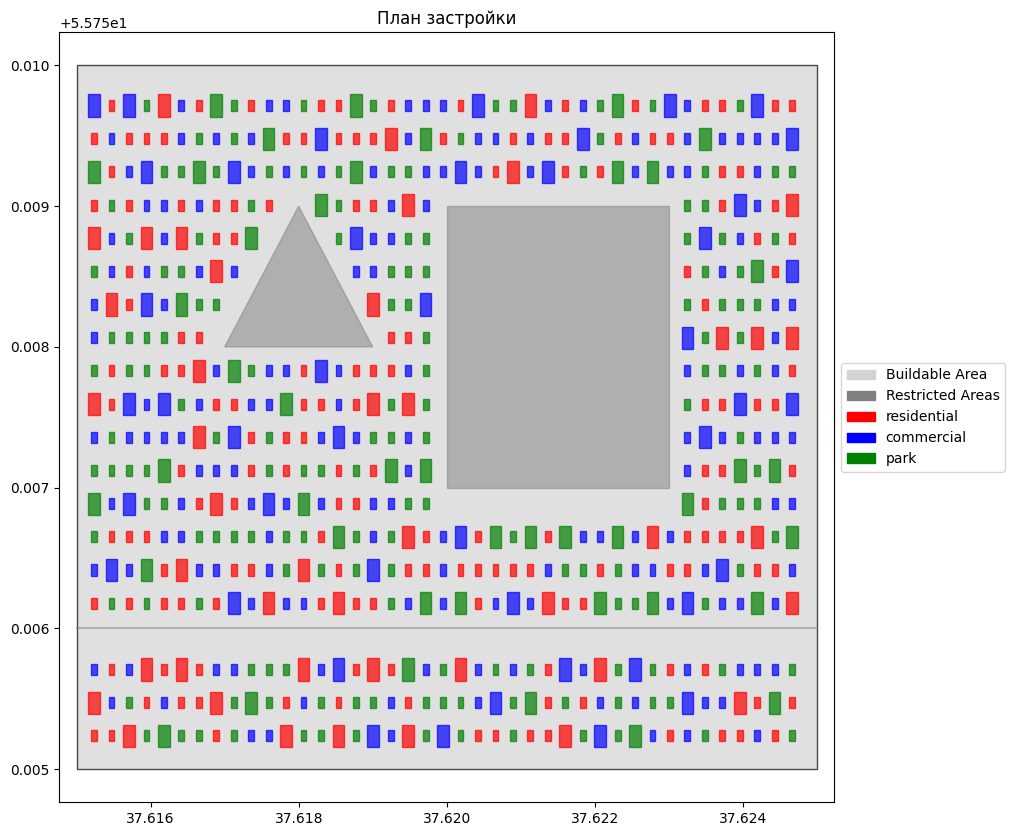

Изображение плана застройки сохранено в output.png


In [7]:
# --- Визуализация ---

fig, ax = plt.subplots(figsize=(10, 10))

# Отрисовка зоны застройки
if isinstance(buildable_area, shapely.geometry.Polygon):
    polygon = mpatches.Polygon(list(buildable_area.exterior.coords), facecolor='lightgray', edgecolor='black', alpha=0.7)
    ax.add_patch(polygon)
buildable_area_patch = mpatches.Patch(color='lightgray', label='Buildable Area')


# Отрисовка зон с ограничениями
if restricted_areas is not None:
    for geom in restricted_areas.geoms:
        if isinstance(geom, shapely.geometry.Polygon):
            polygon = mpatches.Polygon(list(geom.exterior.coords), color='gray', alpha=0.5)
            ax.add_patch(polygon)
        elif isinstance(geom, shapely.geometry.LineString):
            line = mlines.Line2D(*zip(*geom.coords), color='gray', alpha=0.5)
            ax.add_line(line)

restricted_area_patch = mpatches.Patch(color='gray', label='Restricted Areas')


# Отрисовка размещенных объектов
legend_handles = [buildable_area_patch, restricted_area_patch]

for obj, obj_type in zip(placed_objects, [list(object_types.keys())[i%len(object_types)] for i in range(len(placed_objects))]):
    color = object_types[obj_type]["color"]
    if isinstance(obj, shapely.geometry.Polygon):
        polygon = mpatches.Polygon(list(obj.exterior.coords), color=color, alpha=0.7)
        ax.add_patch(polygon)
        legend_handles.append(mpatches.Patch(color=color, label=obj_type))



# Добавление легенды (без дубликатов)
unique_handles = []
unique_labels = []
for handle, label in zip(legend_handles, [h.get_label() for h in legend_handles]):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)


plt.legend(handles=unique_handles, labels=unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Установка заголовка
plt.title("План застройки")

# Установка пределов осей!
minx, miny, maxx, maxy = buildable_area.bounds
ax.set_xlim(minx - max_building_size_deg, maxx + max_building_size_deg)  #  Используем max_building_size_deg
ax.set_ylim(miny - max_building_size_deg, maxy + max_building_size_deg)


# Сохранение изображения
plt.savefig("output.png")

# Показ изображения
plt.show()

print("Изображение плана застройки сохранено в output.png")
